In [1]:
import numpy as np
import pandas as pd

from datetime import date

import quantstats as qs

In [2]:
patterns = {
    'close': 'Fechamento\r\najust p/ prov\r\nEm moeda orig\r\n',
    'negotiable': 'Negociabilidade\n1 meses\nEm moeda orig\n'
}

In [3]:
def clean_dataframe(df, pattern):
    df.columns = df.columns.str.replace(pattern, '')

    dates = pd.to_datetime(df['Data'], dayfirst=True)

    # Detach dates
    tickers = [col for col in df.columns if col != 'Data']
    df = df[tickers]

    # comma_to_dot = lambda x: x.replace('.', '').replace(',', '.')
    # df = df.applymap(comma_to_dot)
    df = df.replace('-', np.nan)
    df = df.apply(pd.to_numeric)

    # Reattach dates
    df['Data'] = dates
    
    # Reorder columns so that dates show up first
    cols = ['Data'] + list(df.columns.drop('Data'))
    df = df[cols]
    
    # Drop weekends and holidays
    df = df.dropna(axis=0, how='all', subset=tickers)
    
    return df

### 1. Load datasets: close quotes and marketability index

In [4]:
path = './../data/close.csv'
close = pd.read_csv(path, delimiter=',')
close = clean_dataframe(close, patterns['close'])

close.tail(2)

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABCB11,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,ESTC11,OPZI3B,ZAMP3,ZIVI4
9613,2022-11-08,47.00,12.13,NaN,NaN,NaN,NaN,NaN,21.50,NaN,...,NaN,NaN,NaN,NaN,13.98,NaN,NaN,NaN,7.1,NaN
9614,2022-11-09,46.21,12.00,NaN,NaN,NaN,NaN,NaN,21.09,NaN,...,NaN,NaN,NaN,NaN,13.72,NaN,NaN,NaN,7.3,NaN


In [5]:
path = './../data/in.csv'
negotiable = pd.read_csv(path, delimiter=',')
negotiable = clean_dataframe(negotiable, patterns['negotiable'])

negotiable.tail(2)

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABCB11,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,ESTC11,OPZI3B,ZAMP3,ZIVI4
9613,2022-11-08,0.61,0.1,NaN,NaN,NaN,NaN,NaN,0.11,NaN,...,NaN,NaN,NaN,NaN,0.47,NaN,NaN,NaN,0.06,NaN
9614,2022-11-09,0.61,0.1,NaN,NaN,NaN,NaN,NaN,0.10,NaN,...,NaN,NaN,NaN,NaN,0.46,NaN,NaN,NaN,0.06,NaN


### 2. Load datasets: P/E and P/B ratios

In [6]:
path = './../data/pe.csv'
peps = pd.read_csv(path)

peps['Data'] = pd.to_datetime(peps['Data'])

In [7]:
peps.tail(2)

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABCB11,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,ESTC11,OPZI3B,ZAMP3,ZIVI4
8576,2022-11-16,48.4161,11.1879,NaN,NaN,NaN,NaN,NaN,5.6840,NaN,...,NaN,12.7022,13.1402,NaN,421.3666,NaN,NaN,NaN,43.9742,NaN
8577,2022-11-17,44.9528,10.6675,NaN,NaN,NaN,NaN,NaN,5.5573,NaN,...,NaN,12.7022,13.1402,NaN,421.3666,NaN,NaN,NaN,43.9742,NaN


In [8]:
path = './../data/pb.csv'
pbook = pd.read_csv(path)

pbook['Data'] = pd.to_datetime(pbook['Data'])

In [9]:
pbook.tail(2)

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABC1,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,EST1,OPZI3B,ZAMP3,ZIVI4
8576,2022-11-16,1.9411,2.2224,NaN,NaN,NaN,NaN,NaN,0.8597,NaN,...,NaN,2.6268,2.7174,NaN,1.1875,NaN,NaN,NaN,1.0987,NaN
8577,2022-11-17,1.8037,2.1190,NaN,NaN,NaN,NaN,NaN,0.8405,NaN,...,NaN,2.6268,2.7174,NaN,1.1482,NaN,NaN,NaN,1.0284,NaN


### 3. Load datasets: ROIC

In [10]:
path = './../data/roic.csv'
roic = pd.read_csv(path)

roic['Data'] = pd.to_datetime(roic['Data'])

In [11]:
def get_roic(_date, tickers):
    stocks_in_roic     = [s for s in tickers if s in roic.columns]
    stocks_not_in_roic = [s for s in tickers if s not in roic.columns]
    
    roic_series = roic.set_index('Data').loc[:_date, stocks_in_roic].iloc[-1]
    
    s_build = dict()
    for s in stocks_not_in_roic:
        equivalent_assets = [asset for asset in roic if s[:4] in asset]
        if len(equivalent_assets) < 1:
            continue
        r = roic.set_index('Data').loc[:today, [equivalent_assets[0]]].iloc[-1][0]
        s_build[s] = r
        
    return pd.concat([roic_series, pd.Series(s_build)]).to_frame(name='roic')

# tickers = get_IBRX_assets(date(2022, 11, 16))
# get_roic(date(2022, 11, 16), tickers).sort_values(by='roic', ascending=False)

### Índice Brasil 100 (IBrX100 B3) — Brazilian marketability index

In [12]:
def get_IBRX_assets(_date):
    s = negotiable.set_index('Data').loc[:_date].iloc[-1]
    s = s.sort_values(ascending=False)
    return s.index[:100]

In [13]:
get_IBRX_assets(date(2022, 11, 10))

Index(['PETR4', 'VALE3', 'ITUB4', 'BBDC4', 'BBAS3', 'MGLU3', 'B3SA3', 'PETR3',
       'ELET3', 'AMER3', 'RENT3', 'ABEV3', 'HAPV3', 'PRIO3', 'LREN3', 'ASAI3',
       'CSAN3', 'BPAC11', 'WEGE3', 'RAIL3', 'SUZB3', 'GGBR4', 'ITSA4', 'NTCO3',
       'VIIA3', 'SBSP3', 'BBSE3', 'MRVE3', 'RADL3', 'JBSS3', 'EQTL3', 'RDOR3',
       'HYPE3', 'CIEL3', 'BRKM5', 'CMIG4', 'CSNA3', 'CYRE3', 'TOTS3', 'VBBR3',
       'BRFS3', 'RRRP3', 'ENEV3', 'COGN3', 'ELET6', 'TIMS3', 'KLBN11', 'AZUL4',
       'PETZ3', 'CCRO3', 'BBDC3', 'USIM5', 'BRAP4', 'CPLE6', 'MULT3', 'YDUQ3',
       'VIVT3', 'UGPA3', 'GOAU4', 'CRFB3', 'MRFG3', 'BRML3', 'GOLL4', 'BEEF3',
       'LWSA3', 'SOMA3', 'SULA11', 'ENGI11', 'SANB11', 'ENBR3', 'ALPA4',
       'EMBR3', 'TAEE11', 'CVCB3', 'ARZZ3', 'RAIZ4', 'GMAT3', 'IGTI11',
       'CPFE3', 'RECV3', 'EGIE3', 'FLRY3', 'IRBR3', 'PCAR3', 'SLCE3', 'AURE3',
       'SMTO3', 'DXCO3', 'PSSA3', 'CBAV3', 'VAMO3', 'MDIA3', 'CASH3', 'MOVI3',
       'TRPL4', 'INTB3', 'CMIN3', 'DIRR3', 'OIBR3', 'QUAL3'],
 

### Momentum

In [14]:
def list_returns(df, today, lookback=1):
    """
    Takes in a DataFrame with time series and lists 
    compounded returns of a dataframe of assets.
    """
    start = today - pd.DateOffset(months=lookback)
    _filter = df.set_index('Data').loc[start:today, :]
    return _filter.pct_change().add(1).cumprod().iloc[-1]

def get_momentum_assets(df, today, lookback=1, assets=10):
    returns = list_returns(df, today, lookback=lookback)
    returns = returns.sort_values(ascending=False).dropna()
    
    if len(returns) < assets:
        return returns.index
    return returns.index[:assets]

In [15]:
def get_ibrx_momentum_asets(_date, lookback=1, assets=10):
    ibrx = get_IBRX_assets(_date)
    cols = list(ibrx) + ['Data']

    ibrx = close.loc[:, cols]
    
    ibrx_assets = get_momentum_assets(ibrx, _date, lookback=lookback, assets=assets)

    return list(ibrx_assets)

### Low Volatility

In [16]:
def rank_stocks_by_volatility(_date, ibrx=True):
    start = _date - pd.DateOffset(years=1)
    end   = _date

    frame   = close.set_index('Data').loc[start:end, :]
    periods = frame.count()

    df = pd.DataFrame(data={'std': frame.std(), 'periods': periods})
    df['volatility'] = df['std'] * df['periods'] ** (1 / 2)
    
    if ibrx:
        tickers = get_IBRX_assets(_date)
        df = df.loc[tickers, :]

    return df

In [17]:
rank_stocks_by_volatility(date(2022, 1, 1)).head()

,std,periods,volatility
PETR4,1.842394,247,28.955495
VALE3,10.305205,247,161.959010
MGLU3,5.631361,247,88.503781
BBDC4,1.816579,247,28.549775
ITUB4,1.398622,247,21.981064


### Value using the Price-Earnings ratio

In [18]:
today = date(2022, 1, 1)
tickers = get_IBRX_assets(today)

pe = peps.set_index('Data').loc[:today, tickers].iloc[-1]
pe = pe.sort_values(ascending=True).to_frame(name='p/e')
pe['posPE'] = range(0, len(pe))

pe

,p/e,posPE
OIBR3,0.0510,0
BRAP4,1.2159,1
USIM5,2.0570,2
GOAU4,2.4295,3
CSNA3,2.8112,4
...,...,...
BIDI4,NaN,95
RRRP3,NaN,96
NUBR33,NaN,97
SANB11,NaN,98


### Backtest

In [19]:
start_date = date(2010, 1, 1)
end_date   = date(2020, 1, 1)

def run_backtest(assets=5, start=start_date, end=end_date, rebalance=1, strategies=['momentum', 'lowvol']):
    today = pd.Timestamp(start)

    portfolio = pd.DataFrame()
    while today.date() <= end:
        portfolio_rebalance = today + pd.DateOffset(months=rebalance)

        # 0. Universe stocks
        universe = get_IBRX_assets(today)

        # 1. Rank, momentum
        lookback = 12  # mês

        start = today - pd.DateOffset(months=lookback)

        _filter = close.set_index('Data').loc[start:today, universe]
        returns = _filter.pct_change().add(1).cumprod().iloc[-1]
        returns = returns.to_frame(name='return').dropna()
        returns = returns.sort_values(by='return', ascending=False)
        returns['posRet'] = range(0, len(returns))

        # 2. Rank, low-vol
        lookback = 1 # years

        start = today - pd.DateOffset(years=1)

        _filter = close.set_index('Data').loc[start:today, universe].pct_change()

        vol               = _filter.std().to_frame(name='std')
        vol['periods']    = _filter.count()
        vol['volatility'] = vol['std'] * vol['periods'] ** (1 / 2)
        vol = vol.sort_values(by='volatility')
        vol['posVol'] = range(0, len(vol))
        
        # 3. Rank, price-earnings
        pe = peps.set_index('Data').loc[:today, universe].iloc[-1]
        pe = pe.sort_values(ascending=True).to_frame(name='p/e')
        pe['posPE'] = range(0, len(pe))
        
        # 4. Rank, price-book
        # pb = pbook.set_index('Data').loc[:today, universe].iloc[-1]
        # pb = pbook.sort_values(ascending=True).to_frame(name='p/e')
        # pb['posPB'] = range(0, len(pb))
        
        # 5. Rank, ROIC
        roic_r = get_roic(today, universe).sort_values(by='roic', ascending=False)
        roic_r['posROIC'] = range(0, len(roic_r))
        
        # Assemble ranking
        concat_ranking = []
        concat_columns = []
        
        if 'momentum' in strategies:
            concat_ranking.append(returns)
            concat_columns.append('posRet')
        if 'lowvol' in strategies:
            concat_ranking.append(vol)
            concat_columns.append('posVol')
        if 'value' in strategies:
            concat_ranking.append(pe)
            concat_columns.append('posPE')
        if 'quality' in strategies:
            concat_ranking.append(roic_r)
            concat_columns.append('posROIC')
            
        ranking = pd.concat(concat_ranking, axis=1).loc[:, concat_columns]
        ranking = ranking.dropna(axis='index', how='any')
        ranking['pos'] = sum([ranking[pos] for pos in concat_columns])
        
        tickers = ranking.sort_values(by='pos').index[:assets]

        # === End stock picking here ===

        # Offset: How many days has it been since the last trading day?
        # Why? because if it is January 4th, we buy assets for January 3rd closing prices
        day = close.set_index('Data').loc[:today].reset_index().iloc[-1]['Data']
        offset = today - day

        wf = close.set_index('Data').loc[today - offset:portfolio_rebalance - pd.DateOffset(days=1), tickers]
        wf = wf.pct_change()

        portfolio = pd.concat([portfolio, wf.iloc[1:].mean(axis=1)])

        today = portfolio_rebalance
        
    return portfolio.add(1).cumprod()

### Use QuantStats to extract portfolio analysis

In [20]:
benchmark = pd.read_csv('./../data/benchmark.csv')
benchmark['Date'] = pd.to_datetime(benchmark['Date'])
benchmark = benchmark.set_index('Date')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2010-01-04  2010-01-04
End Period                 2020-03-31  2020-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      78.0%

Cumulative Return          411.32%     43.86%
CAGR﹪                     17.27%      3.61%

Sharpe                     0.83        0.27
Prob. Sharpe Ratio         99.37%      80.36%
Smart Sharpe               0.8         0.26
Sortino                    1.12        0.38
Smart Sortino              1.08        0.37
Sortino/√2                 0.79        0.27
Smart Sortino/√2           0.77        0.26
Omega                      1.17        1.17

Max Drawdown               -51.08%     -47.56%
Longest DD Days            682         1349
Volatility (ann.)          23.12%      24.83%
R^2                        0.43        0.43
Information Ratio          0.04        0.04
Calmar                     0.34        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-23,2020-03-31,40,-51.079440,-48.280433
2,2014-09-01,2016-01-20,2016-07-14,682,-25.155720,-24.676484
3,2011-06-06,2011-08-08,2012-01-19,227,-21.126650,-16.839296
4,2010-01-12,2010-05-20,2010-07-29,198,-18.261362,-17.843980
5,2013-05-23,2013-06-24,2013-10-10,140,-15.242866,-14.183761


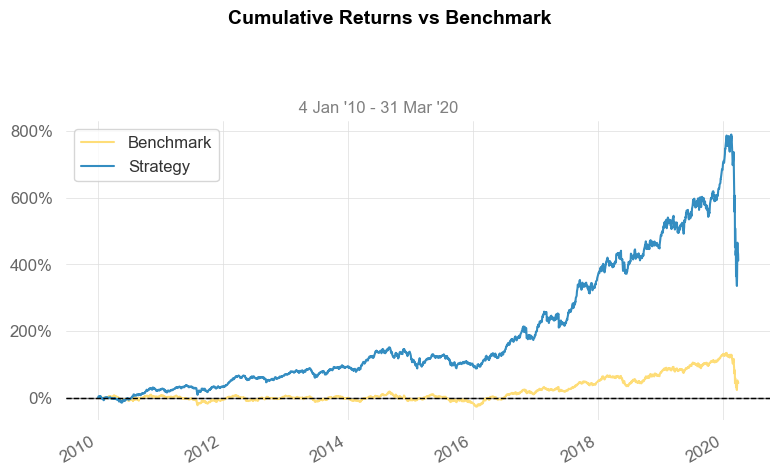

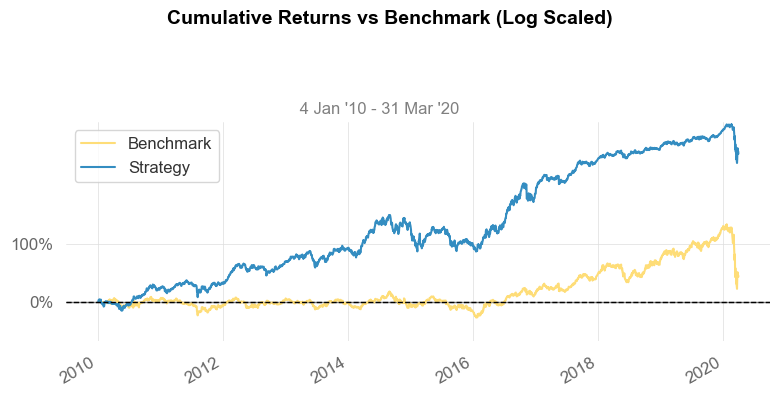

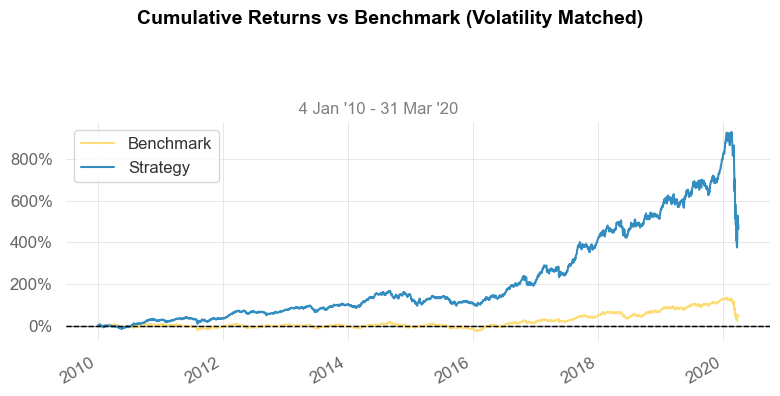

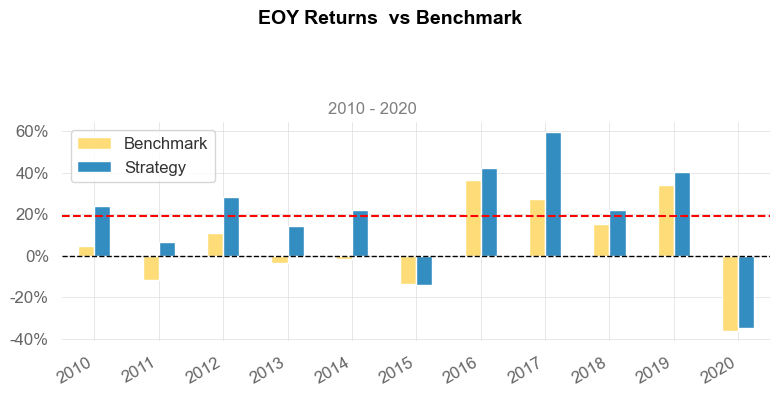

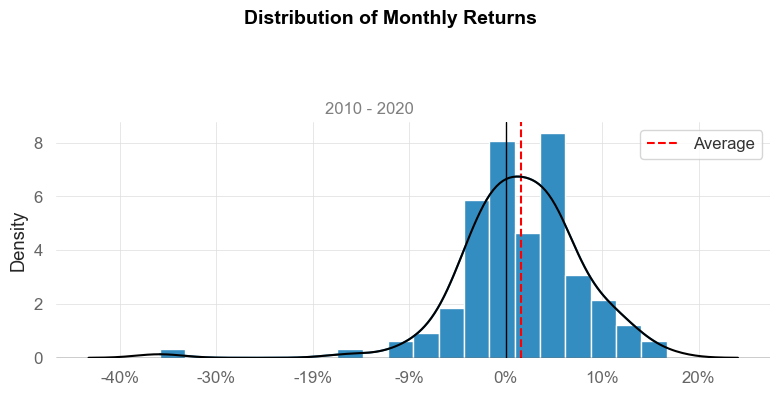

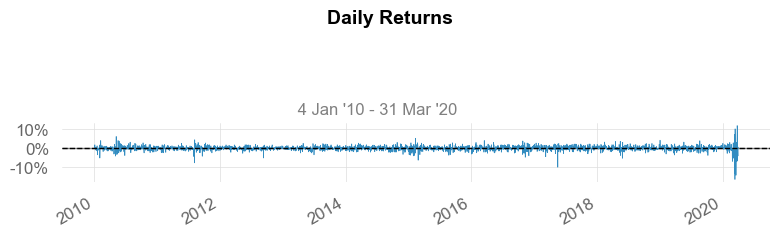

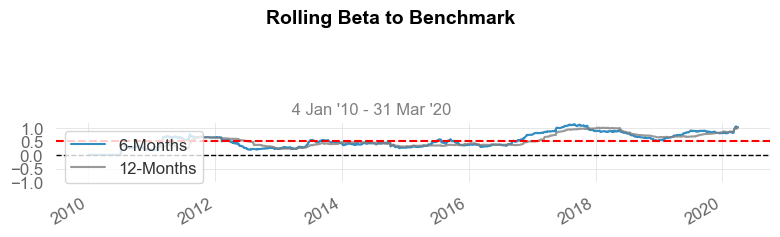

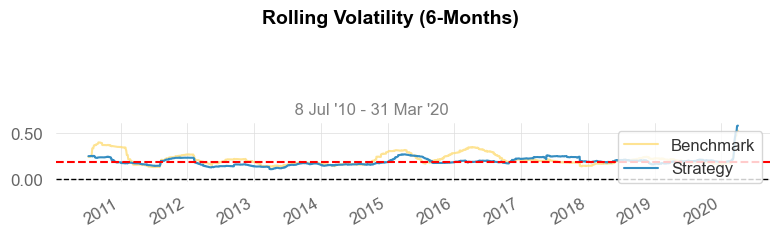

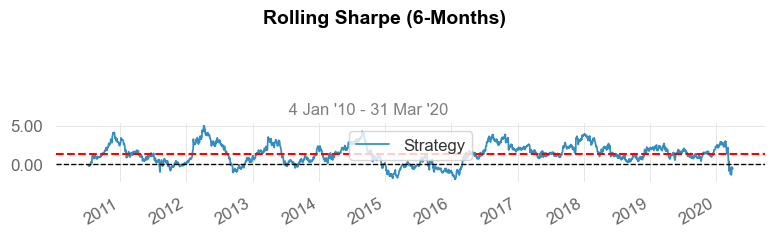

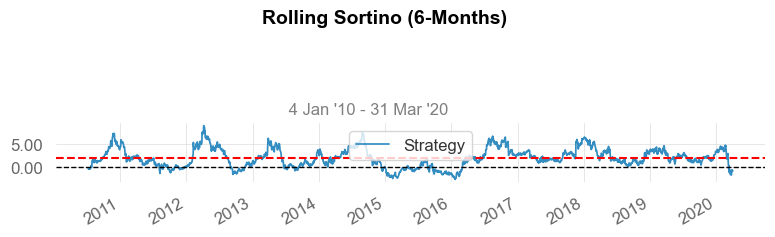

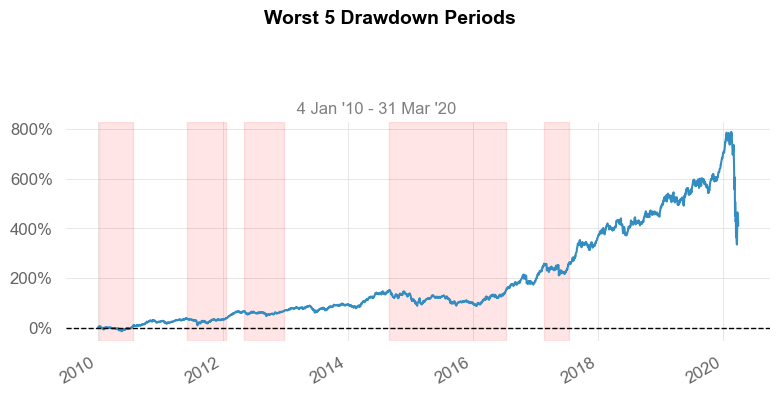

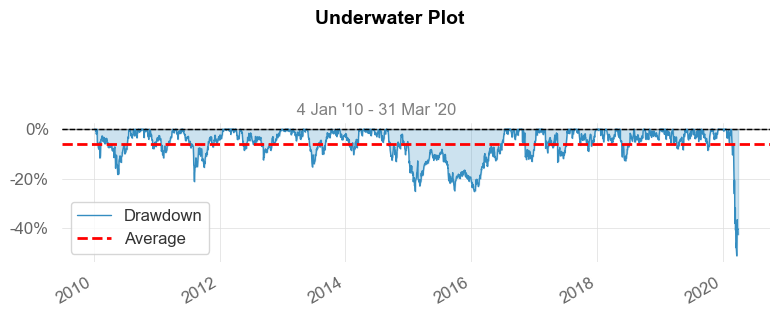

/Users/pedro/Developer/quant-modeling/venv/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


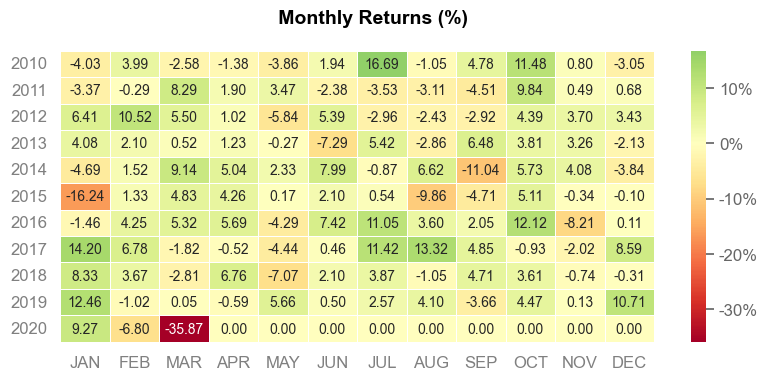

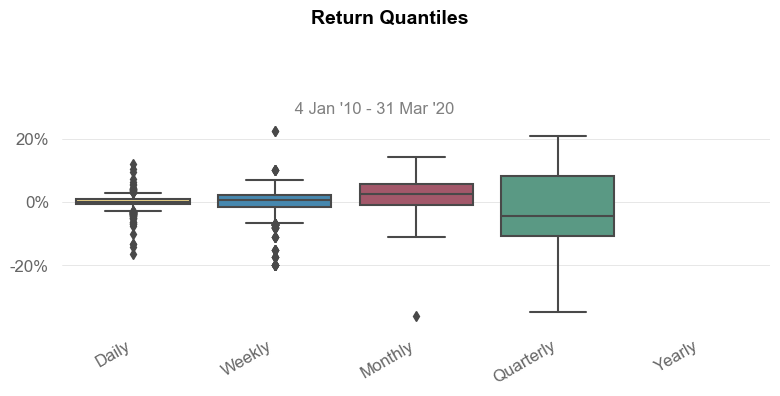

In [21]:
%matplotlib inline

qs.extend_pandas()

portfolio = run_backtest(assets=10, strategies=['quality', 'value', 'momentum'], rebalance=3)
qs.reports.full(portfolio[0], benchmark.Close)